In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

background_image = cv2.imread('background.jpg', cv2.IMREAD_GRAYSCALE)
blurred_image = cv2.imread('blurred.jpg', cv2.IMREAD_GRAYSCALE)

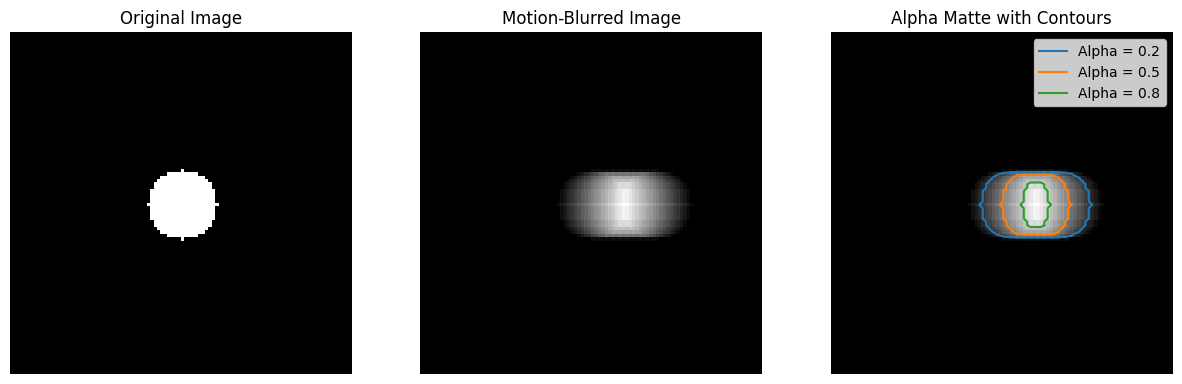

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.measure import find_contours

def create_synthetic_image(size, object_coords):
    """
    Create a simple synthetic image with an object.
    
    Args:
        size (tuple): Size of the image (height, width).
        object_coords (tuple): Coordinates for the object (x, y, radius).

    Returns:
        numpy.ndarray: Binary image with the object.
    """
    image = np.zeros(size, dtype=np.float32)
    x, y, radius = object_coords
    for i in range(size[0]):
        for j in range(size[1]):
            if (i - y) ** 2 + (j - x) ** 2 <= radius ** 2:
                image[i, j] = 1.0
    return image

def apply_motion_blur(image, direction, num_steps):
    """
    Simulate motion blur by averaging shifted versions of the image.

    Args:
        image (numpy.ndarray): Original image.
        direction (tuple): Direction of motion as (dx, dy).
        num_steps (int): Number of steps for motion blur.

    Returns:
        numpy.ndarray: Motion-blurred image.
    """
    height, width = image.shape
    dx, dy = direction
    blurred_image = np.zeros_like(image)

    for step in range(num_steps):
        shift_x = int(step * dx / num_steps)
        shift_y = int(step * dy / num_steps)
        shifted_image = np.roll(np.roll(image, shift_x, axis=1), shift_y, axis=0)
        blurred_image += shifted_image

    return blurred_image / num_steps

def extract_alpha_matte(blurred_image, background_intensity=0.0):
    """
    Extract the alpha matte from a motion-blurred image.

    Args:
        blurred_image (numpy.ndarray): The motion-blurred image.
        background_intensity (float): Intensity of the background.

    Returns:
        numpy.ndarray: Alpha matte representing transparency values.
    """
    alpha_matte = (blurred_image - background_intensity) / (1.0 - background_intensity)
    alpha_matte = np.clip(alpha_matte, 0, 1)  
    return alpha_matte

def extract_contours(alpha_matte, levels):
    """
    Extract contours at specific alpha levels from the alpha matte.

    Args:
        alpha_matte (numpy.ndarray): The alpha matte image.
        levels (list): Alpha values at which to extract contours.

    Returns:
        list: Contours extracted at the specified levels.
    """
    contours = []
    for level in levels:
        contours_at_level = find_contours(alpha_matte, level)
        contours.append((level, contours_at_level))
    return contours


image_size = (100, 100)
object_coords = (50, 50, 10)  
motion_direction = (20, 0)   
num_steps = 50


original_image = create_synthetic_image(image_size, object_coords)
blurred_image = apply_motion_blur(original_image, motion_direction, num_steps)


alpha_matte = extract_alpha_matte(blurred_image)

alpha_levels = [0.2, 0.5, 0.8]  # Contour levels
contours = extract_contours(alpha_matte, alpha_levels)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Motion-Blurred Image")
plt.imshow(blurred_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Alpha Matte with Contours")
plt.imshow(alpha_matte, cmap="gray")
for level, contour_set in contours:
    for contour in contour_set:
        plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
plt.legend(loc="upper right")
plt.axis("off")

plt.show()


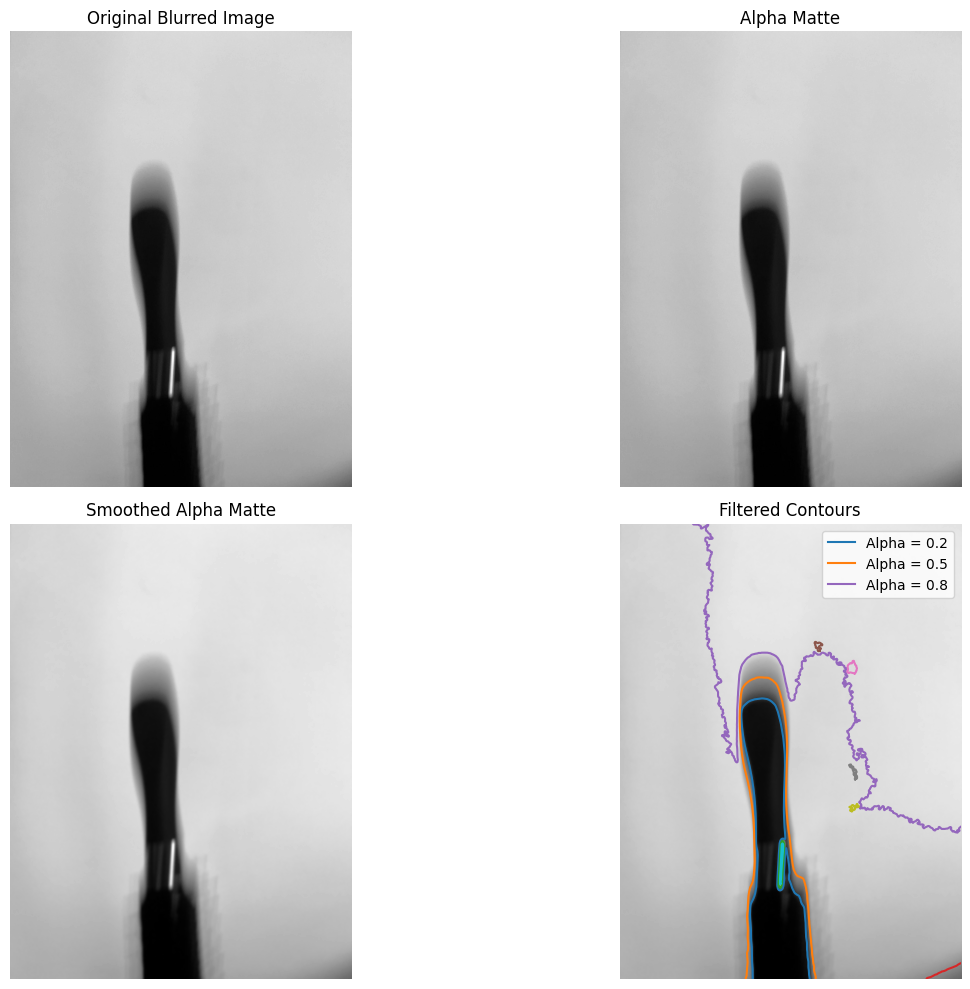

In [17]:
def load_image(image_path):
    image = imread(image_path)
    if len(image.shape) == 3:
        image = rgb2gray(image)
    return image / 255.0

def extract_alpha_matte(blurred_image):
    return blurred_image / np.max(blurred_image)

def smooth_alpha_matte(alpha_matte, sigma=2):
    return gaussian_filter(alpha_matte, sigma=sigma)

def extract_contours(alpha_matte, levels, min_length=50):
    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = [c for c in contour_set if len(c) > min_length]
        contours.append((level, filtered_contours))
    return contours

image_path = "blurred.jpg"
alpha_levels = [0.2, 0.5, 0.8]
min_contour_length = 50

blurred_image = load_image(image_path)
alpha_matte = extract_alpha_matte(blurred_image)
smoothed_alpha = smooth_alpha_matte(alpha_matte, sigma=2)
contours = extract_contours(smoothed_alpha, alpha_levels, min_length=min_contour_length)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Original Blurred Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(alpha_matte, cmap="gray")
plt.title("Alpha Matte")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(smoothed_alpha, cmap="gray")
plt.title("Smoothed Alpha Matte")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(smoothed_alpha, cmap="gray")
used_labels = set()
for level, contour_set in contours:
    for contour in contour_set:
        if level not in used_labels:
            plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
            used_labels.add(level)
        else:
            plt.plot(contour[:, 1], contour[:, 0])
plt.legend(loc="upper right")
plt.title("Filtered Contours")
plt.axis("off")

plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_34436\2022260531.py:13: RuntimeWarning: divide by zero encountered in divide
  alpha_matte = (blurred_image - background_image) / (object_intensity - background_image)
C:\Users\User\AppData\Local\Temp\ipykernel_34436\2022260531.py:13: RuntimeWarning: invalid value encountered in divide
  alpha_matte = (blurred_image - background_image) / (object_intensity - background_image)


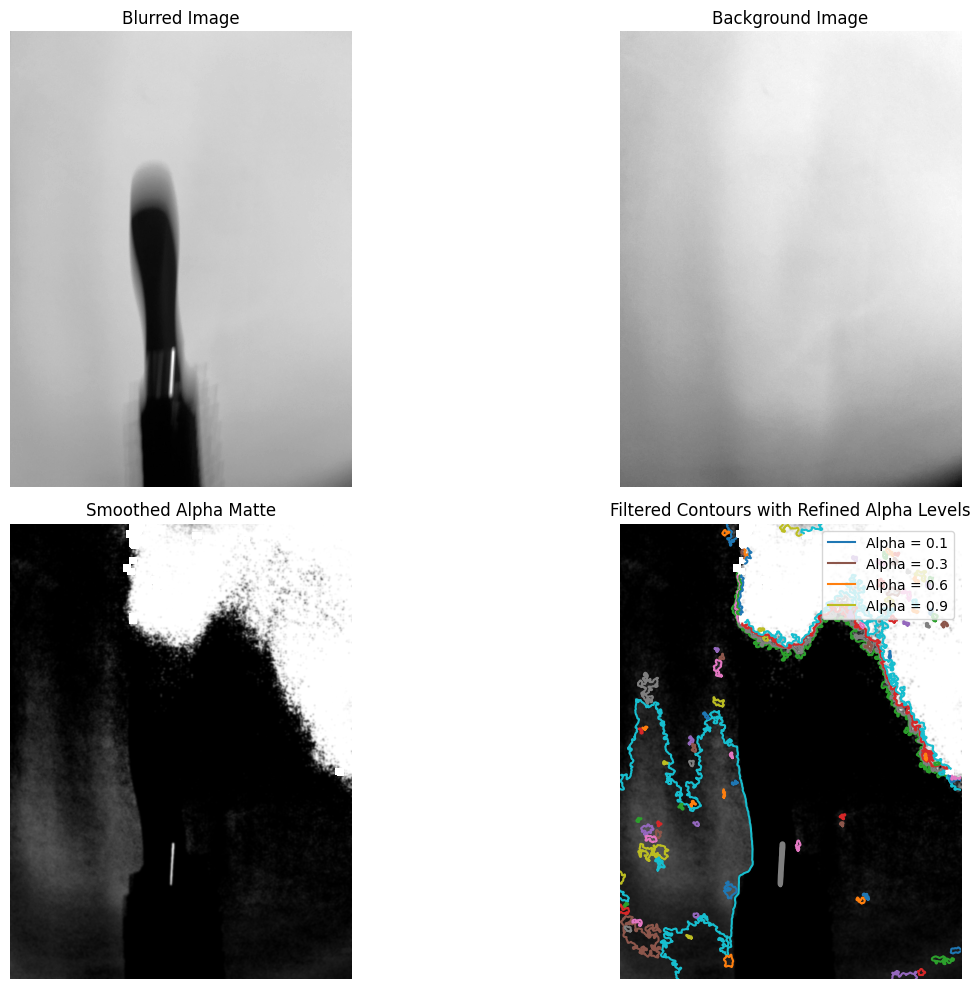

In [18]:


def compute_alpha_matte(blurred_image, background_image, object_intensity):
    """
    Compute the alpha matte using the paper's model.

    Args:
        blurred_image (numpy.ndarray): Motion-blurred image (C(p)).
        background_image (numpy.ndarray): Background intensity (B(p)).
        object_intensity (float): Estimated object intensity (o(p)).

    Returns:
        numpy.ndarray: Alpha matte values clipped to [0, 1].
    """
    alpha_matte = (blurred_image - background_image) / (object_intensity - background_image)
    alpha_matte = np.clip(alpha_matte, 0, 1)  
    return alpha_matte

def extract_contours(alpha_matte, levels, min_length=50):
    """
    Extract contours at specific alpha levels from the alpha matte and filter by length.

    Args:
        alpha_matte (numpy.ndarray): The alpha matte image.
        levels (list): Alpha values at which to extract contours.
        min_length (int): Minimum length of contours to retain.

    Returns:
        list: Filtered contours extracted at the specified levels.
    """
    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = [c for c in contour_set if len(c) > min_length]  # Filter by length
        contours.append((level, filtered_contours))
    return contours


blurred_image_path = "blurred.jpg"  # Path to the motion-blurred image
background_image_path = "background.jpg"  # Path to the background image
alpha_levels = [0.1, 0.3, 0.6, 0.9]  # Adjusted alpha levels for finer testing
min_contour_length = 50  # Minimum length of contours to retain


blurred_image = load_image(blurred_image_path)
background_image = load_image(background_image_path)

# Estimate object intensity (e.g., maximum intensity in the blurred image)
object_intensity = np.percentile(blurred_image, 99)  # High percentile for object intensity

# Compute alpha matte
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)

# Smooth the alpha matte
smoothed_alpha = smooth_alpha_matte(alpha_matte, sigma=2)

# Extract and filter contours
contours = extract_contours(smoothed_alpha, alpha_levels, min_length=min_contour_length)

# Display the results
plt.figure(figsize=(15, 10))

# Display the original blurred image
plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image")
plt.axis("off")

# Display the background image
plt.subplot(2, 2, 2)
plt.imshow(background_image, cmap="gray")
plt.title("Background Image")
plt.axis("off")

# Display the smoothed alpha matte
plt.subplot(2, 2, 3)
plt.imshow(smoothed_alpha, cmap="gray")
plt.title("Smoothed Alpha Matte")
plt.axis("off")

# Display filtered contours
plt.subplot(2, 2, 4)
plt.imshow(smoothed_alpha, cmap="gray")
used_labels = set()  # Track labels to prevent duplicates
for level, contour_set in contours:
    for contour in contour_set:
        if level not in used_labels:  # Add label only once
            plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
            used_labels.add(level)
        else:
            plt.plot(contour[:, 1], contour[:, 0])  # No label for duplicates
plt.legend(loc="upper right")
plt.title("Filtered Contours with Refined Alpha Levels")
plt.axis("off")

plt.tight_layout()
plt.show()


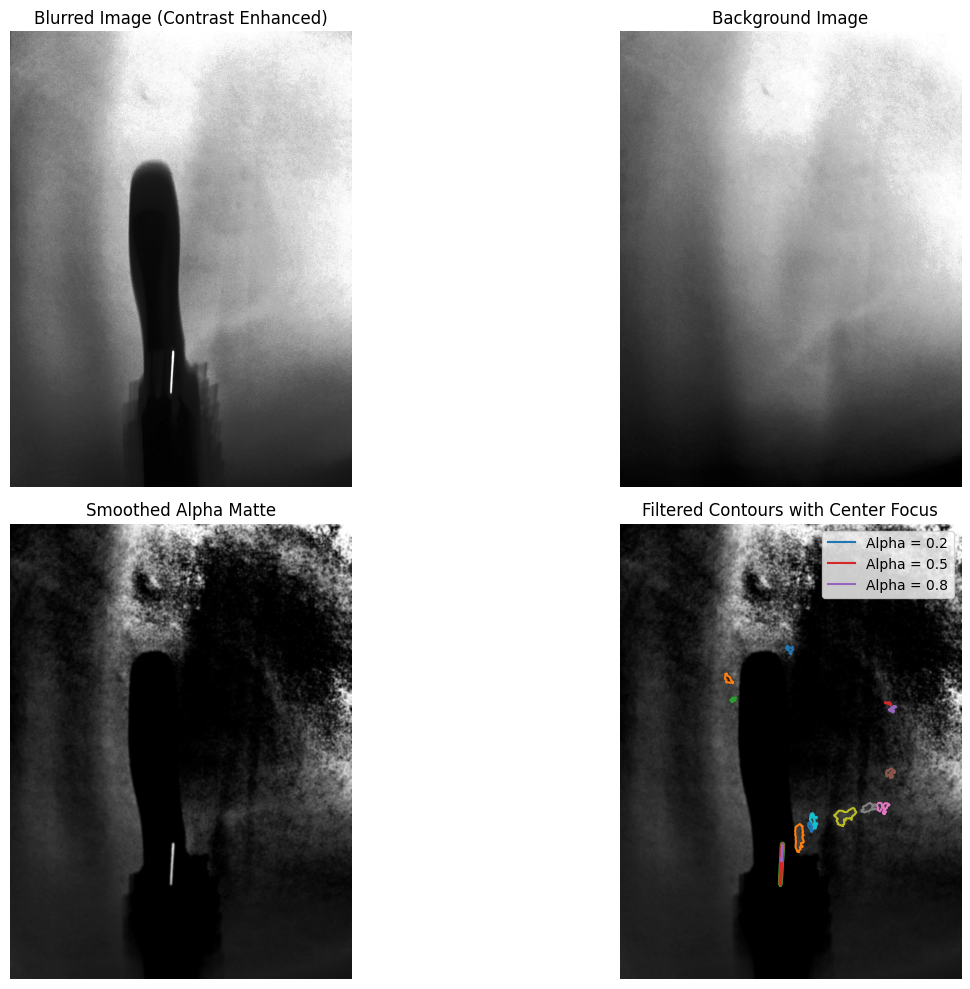

In [19]:
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist

# Step 1: Load and Preprocess Image
def load_image(image_path):
    """
    Load and preprocess an image with contrast enhancement.

    Args:
        image_path (str): Path to the image file.

    Returns:
        numpy.ndarray: Grayscale image normalized to [0, 1].
    """
    image = imread(image_path)
    if len(image.shape) == 3:  # Convert RGB to grayscale if needed
        image = rgb2gray(image)
    image = image / 255.0  # Normalize to [0, 1]
    return equalize_hist(image)  # Enhance contrast

# Step 2: Compute Alpha Matte
def compute_alpha_matte(blurred_image, background_image, object_intensity):
    """
    Compute the alpha matte using the paper's model.

    Args:
        blurred_image (numpy.ndarray): Motion-blurred image (C(p)).
        background_image (numpy.ndarray): Background intensity (B(p)).
        object_intensity (float): Estimated object intensity (o(p)).

    Returns:
        numpy.ndarray: Alpha matte values clipped to [0, 1].
    """
    alpha_matte = (blurred_image - background_image) / (object_intensity - background_image)
    alpha_matte = np.clip(alpha_matte, 0, 1)  # Ensure alpha values are in [0, 1]
    return alpha_matte

# Step 3: Smooth Alpha Matte
def smooth_alpha_matte(alpha_matte, sigma=2):
    """
    Smooth the alpha matte using a Gaussian filter.

    Args:
        alpha_matte (numpy.ndarray): The alpha matte image.
        sigma (float): The standard deviation for Gaussian filter.

    Returns:
        numpy.ndarray: Smoothed alpha matte.
    """
    return gaussian_filter(alpha_matte, sigma=sigma)

# Step 4: Extract Contours
def extract_contours(alpha_matte, levels, min_length=50, center_focus=True):
    """
    Extract contours at specific alpha levels from the alpha matte and filter by length.

    Args:
        alpha_matte (numpy.ndarray): The alpha matte image.
        levels (list): Alpha values at which to extract contours.
        min_length (int): Minimum length of contours to retain.
        center_focus (bool): Whether to prioritize contours near the center.

    Returns:
        list: Filtered contours extracted at the specified levels.
    """
    height, width = alpha_matte.shape
    center = np.array([height / 2, width / 2])

    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = []
        for c in contour_set:
            if len(c) > min_length:
                if center_focus:
                    # Prioritize contours closer to the center
                    distance = np.mean(np.linalg.norm(c - center, axis=1))
                    if distance < max(height, width) / 4:  # Within 25% of the center
                        filtered_contours.append(c)
                else:
                    filtered_contours.append(c)
        contours.append((level, filtered_contours))
    return contours

# Parameters
blurred_image_path = "blurred.jpg"  # Path to the motion-blurred image
background_image_path = "background.jpg"  # Path to the background image
alpha_levels = [0.2, 0.5, 0.8]  # Contour levels
min_contour_length = 50  # Minimum length of contours to retain

# Load the blurred and background images
blurred_image = load_image(blurred_image_path)
background_image = load_image(background_image_path)

# Estimate object intensity (e.g., maximum intensity in the blurred image)
object_intensity = np.percentile(blurred_image, 99)  # High percentile for object intensity

# Compute alpha matte
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)

# Smooth the alpha matte
smoothed_alpha = smooth_alpha_matte(alpha_matte, sigma=2)

# Extract and filter contours
contours = extract_contours(smoothed_alpha, alpha_levels, min_length=min_contour_length, center_focus=True)

# Display the results
plt.figure(figsize=(15, 10))

# Display the original blurred image
plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image (Contrast Enhanced)")
plt.axis("off")

# Display the background image
plt.subplot(2, 2, 2)
plt.imshow(background_image, cmap="gray")
plt.title("Background Image")
plt.axis("off")

# Display the smoothed alpha matte
plt.subplot(2, 2, 3)
plt.imshow(smoothed_alpha, cmap="gray")
plt.title("Smoothed Alpha Matte")
plt.axis("off")

# Display filtered contours
plt.subplot(2, 2, 4)
plt.imshow(smoothed_alpha, cmap="gray")
used_labels = set()  # Track labels to prevent duplicates
for level, contour_set in contours:
    for contour in contour_set:
        if level not in used_labels:  # Add label only once
            plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
            used_labels.add(level)
        else:
            plt.plot(contour[:, 1], contour[:, 0])  # No label for duplicates
plt.legend(loc="upper right")
plt.title("Filtered Contours with Center Focus")
plt.axis("off")

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_34436\2239551484.py:12: RuntimeWarning: divide by zero encountered in divide
  alpha_matte = (blurred_image - background_image) / (object_intensity - background_image)
C:\Users\User\AppData\Local\Temp\ipykernel_34436\2239551484.py:12: RuntimeWarning: invalid value encountered in divide
  alpha_matte = (blurred_image - background_image) / (object_intensity - background_image)


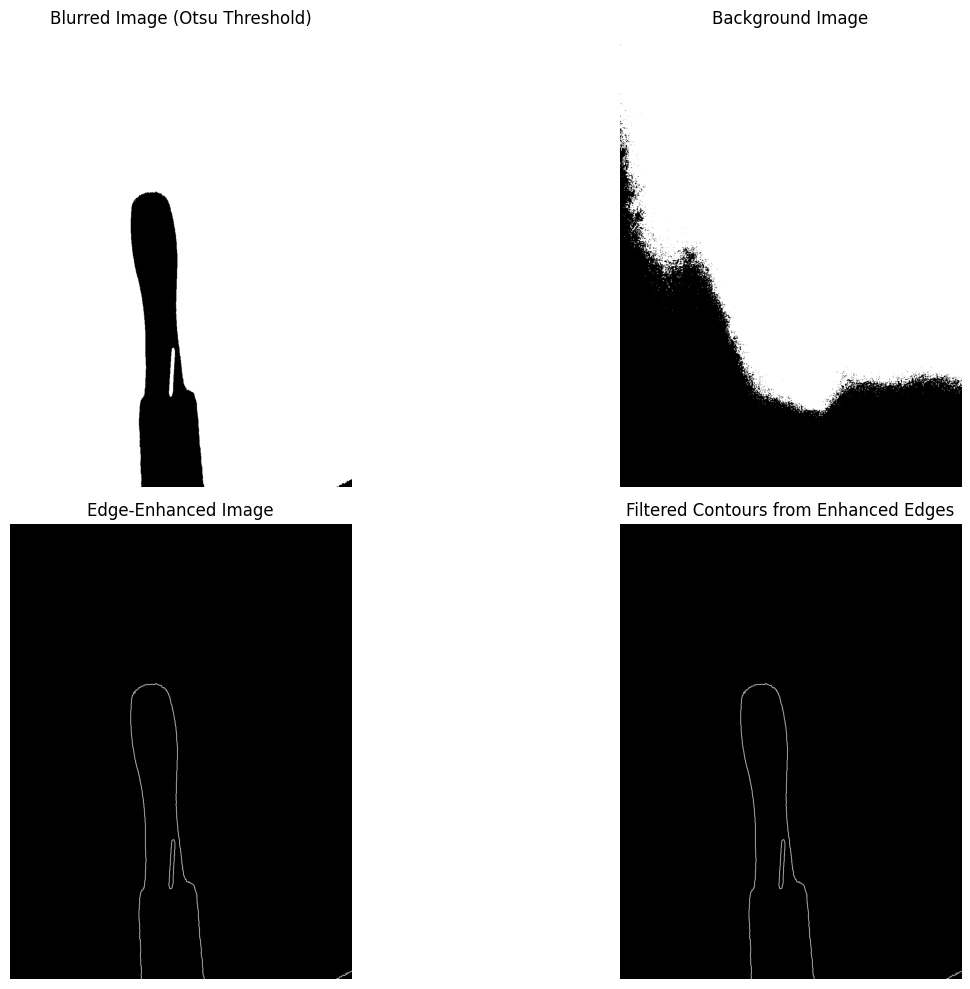

In [20]:
from scipy.ndimage import sobel
from skimage.io import imread
from skimage.filters import threshold_otsu

def load_image(image_path):
    image = imread(image_path, as_gray=True) / 255.0
    thresh = threshold_otsu(image)
    binary_image = image > thresh
    return binary_image.astype(float)

def compute_alpha_matte(blurred_image, background_image, object_intensity):
    alpha_matte = (blurred_image - background_image) / (object_intensity - background_image)
    return np.clip(alpha_matte, 0, 1)

def enhance_edges(image):
    sobel_x = sobel(image, axis=0)
    sobel_y = sobel(image, axis=1)
    edges = np.hypot(sobel_x, sobel_y)
    edges /= edges.max()
    return edges

blurred_image_path = "blurred.jpg"
background_image_path = "background.jpg"
alpha_levels = [0.2, 0.5, 0.8]
min_contour_length = 50

blurred_image = load_image(blurred_image_path)
background_image = load_image(background_image_path)
object_intensity = np.percentile(blurred_image, 99)
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)
edge_enhanced = enhance_edges(blurred_image)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image (Otsu Threshold)")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(background_image, cmap="gray")
plt.title("Background Image")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(edge_enhanced, cmap="gray")
plt.title("Edge-Enhanced Image")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(edge_enhanced, cmap="gray")
plt.title("Filtered Contours from Enhanced Edges")
plt.axis("off")

plt.tight_layout()
plt.show()

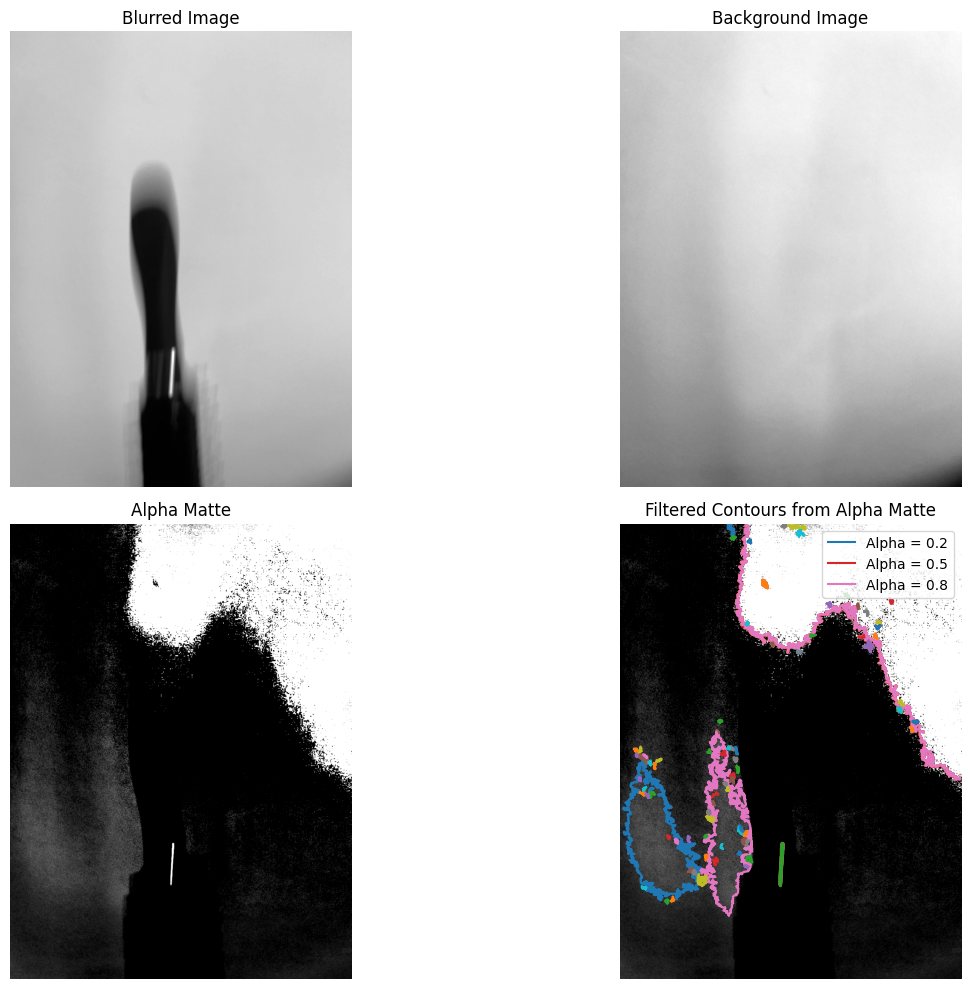

In [21]:
def load_image(image_path):
    image = imread(image_path, as_gray=True) / 255.0
    return image

def compute_alpha_matte(C, B, o):
    denominator = o - B
    denominator[denominator == 0] = np.finfo(float).eps
    alpha_matte = (C - B) / denominator
    return np.clip(alpha_matte, 0, 1)

def enhance_edges(image):
    sobel_x = sobel(image, axis=0)
    sobel_y = sobel(image, axis=1)
    edges = np.hypot(sobel_x, sobel_y)
    edges /= edges.max()
    return edges

def extract_contours(alpha_matte, levels, min_length=50):
    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = [c for c in contour_set if len(c) > min_length]
        contours.append((level, filtered_contours))
    return contours

blurred_image_path = "blurred.jpg"
background_image_path = "background.jpg"
alpha_levels = [0.2, 0.5, 0.8]
min_contour_length = 50

blurred_image = load_image(blurred_image_path)
background_image = load_image(background_image_path)
object_intensity = np.percentile(blurred_image, 99)
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)
edge_enhanced = enhance_edges(alpha_matte)
contours = extract_contours(alpha_matte, alpha_levels, min_length=min_contour_length)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(background_image, cmap="gray")
plt.title("Background Image")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(alpha_matte, cmap="gray")
plt.title("Alpha Matte")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(alpha_matte, cmap="gray")
used_labels = set()
for level, contour_set in contours:
    for contour in contour_set:
        if level not in used_labels:
            plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
            used_labels.add(level)
        else:
            plt.plot(contour[:, 1], contour[:, 0])
plt.legend(loc="upper right")
plt.title("Filtered Contours from Alpha Matte")
plt.axis("off")
plt.tight_layout()
plt.show()

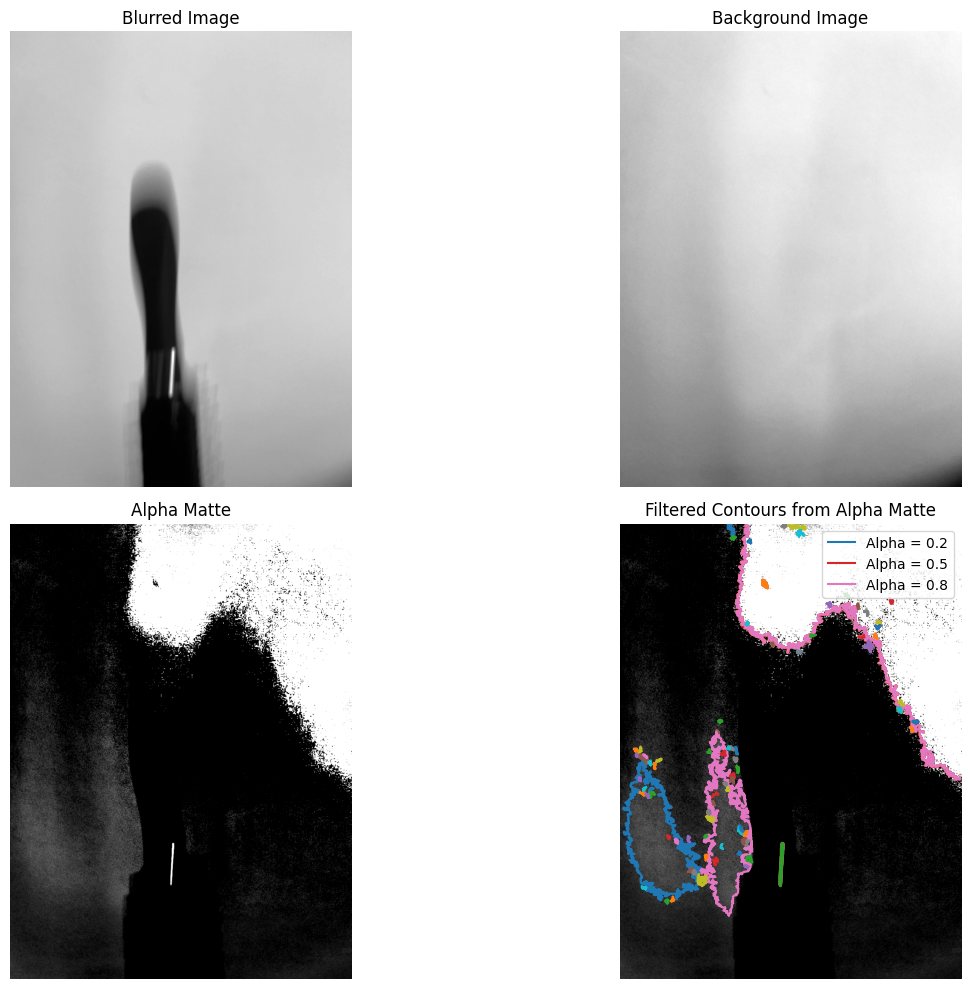

In [22]:
def load_image(image_path):
    image = imread(image_path, as_gray=True) / 255.0
    return image

def compute_alpha_matte(C, B, o):
    denominator = o - B
    denominator[denominator == 0] = np.finfo(float).eps
    alpha_matte = (C - B) / denominator
    return np.clip(alpha_matte, 0, 1)

def enhance_edges(image):
    sobel_x = sobel(image, axis=0)
    sobel_y = sobel(image, axis=1)
    edges = np.hypot(sobel_x, sobel_y)
    edges /= edges.max()
    return edges

def extract_contours(alpha_matte, levels, min_length=50):
    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = [c for c in contour_set if len(c) > min_length]
        contours.append((level, filtered_contours))
    return contours

blurred_image_path = "blurred.jpg"
background_image_path = "background.jpg"
alpha_levels = [0.2, 0.5, 0.8]
min_contour_length = 50

blurred_image = load_image(blurred_image_path)
background_image = load_image(background_image_path)
object_intensity = np.percentile(blurred_image, 99)
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)
edge_enhanced = enhance_edges(alpha_matte)
contours = extract_contours(alpha_matte, alpha_levels, min_length=min_contour_length)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(background_image, cmap="gray")
plt.title("Background Image")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(alpha_matte, cmap="gray")
plt.title("Alpha Matte")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(alpha_matte, cmap="gray")
used_labels = set()
for level, contour_set in contours:
    for contour in contour_set:
        if level not in used_labels:
            plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
            used_labels.add(level)
        else:
            plt.plot(contour[:, 1], contour[:, 0])
plt.legend(loc="upper right")
plt.title("Filtered Contours from Alpha Matte")
plt.axis("off")

plt.tight_layout()
plt.show()


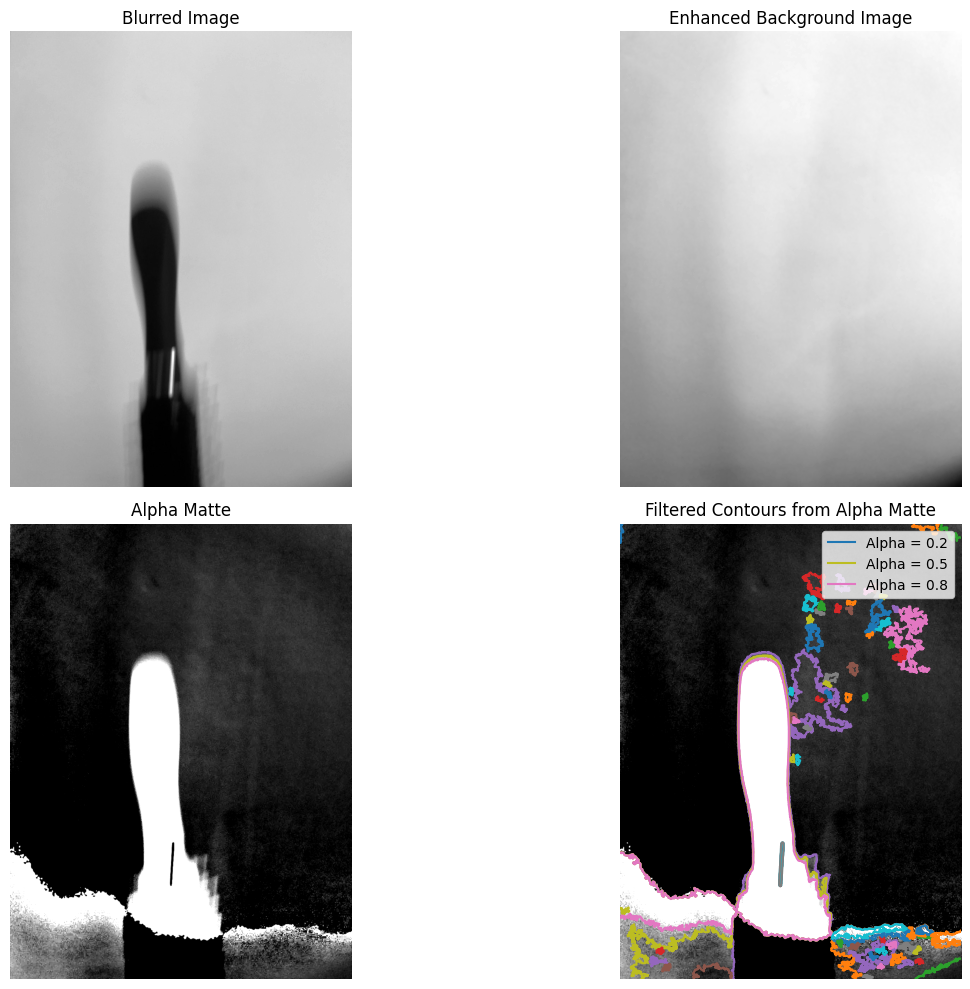

In [23]:
def load_image(image_path):
    image = imread(image_path, as_gray=True) / 255.0
    return image

def compute_alpha_matte(C, B, o):
    denominator = o - B
    denominator[denominator == 0] = np.finfo(float).eps
    alpha_matte = (C - B) / denominator
    return np.clip(alpha_matte, 0, 1)

def enhance_background(background_image):
    return gaussian_filter(background_image, sigma=2)

def determine_object_intensity(blurred_image):
    height, width = blurred_image.shape
    central_region = blurred_image[height // 4: 3 * height // 4, width // 4: 3 * width // 4]
    return np.mean(central_region)

def extract_contours(alpha_matte, levels, min_length=100):
    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = [c for c in contour_set if len(c) > min_length]
        contours.append((level, filtered_contours))
    return contours

blurred_image_path = "blurred.jpg"
background_image_path = "background.jpg"
alpha_levels = [0.2, 0.5, 0.8]
min_contour_length = 100

blurred_image = load_image(blurred_image_path)
background_image = load_image(background_image_path)
background_image = enhance_background(background_image)
object_intensity = determine_object_intensity(blurred_image)
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)
contours = extract_contours(alpha_matte, alpha_levels, min_length=min_contour_length)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(background_image, cmap="gray")
plt.title("Enhanced Background Image")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(alpha_matte, cmap="gray")
plt.title("Alpha Matte")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(alpha_matte, cmap="gray")
used_labels = set()
for level, contour_set in contours:
    for contour in contour_set:
        if level not in used_labels:
            plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
            used_labels.add(level)
        else:
            plt.plot(contour[:, 1], contour[:, 0])
plt.legend(loc="upper right")
plt.title("Filtered Contours from Alpha Matte")
plt.axis("off")

plt.tight_layout()
plt.show()

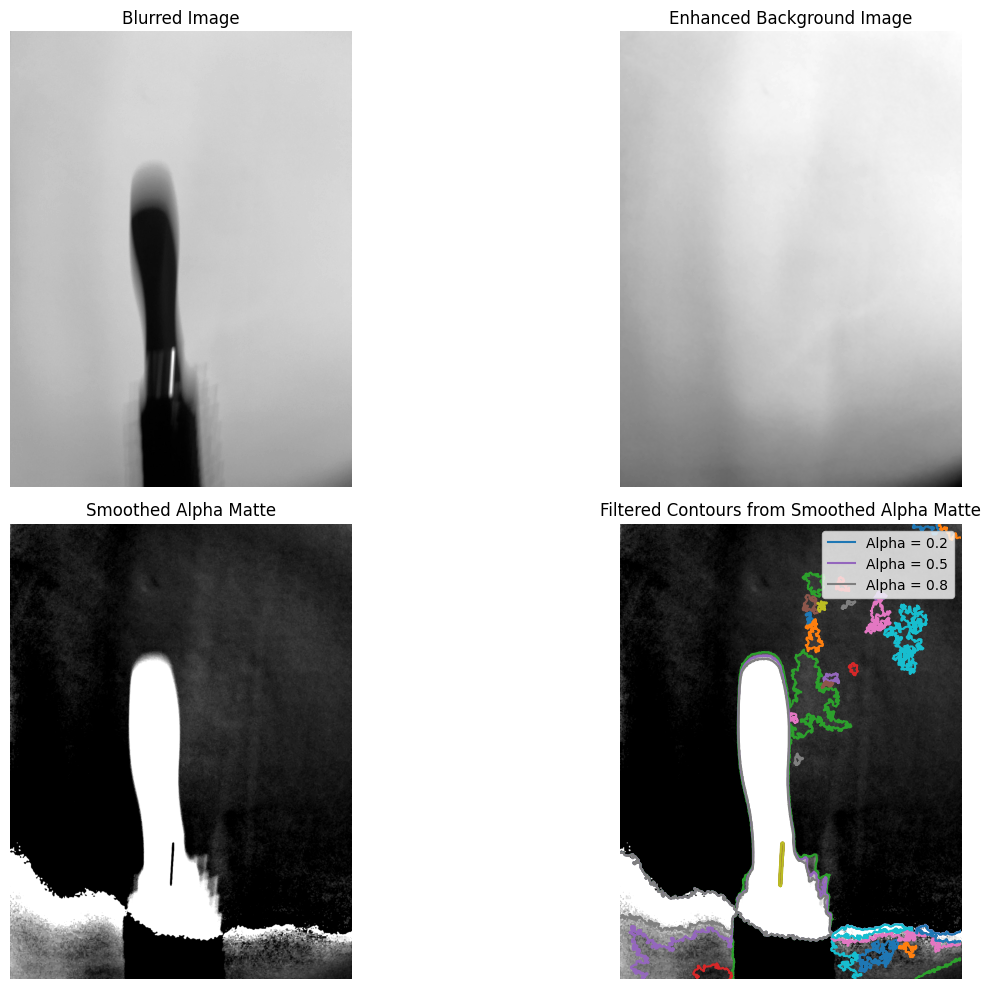

In [24]:
def load_image(image_path):
    image = imread(image_path, as_gray=True) / 255.0
    return image

def compute_alpha_matte(C, B, o):
    denominator = o - B
    denominator[denominator == 0] = np.finfo(float).eps
    alpha_matte = (C - B) / denominator
    return np.clip(alpha_matte, 0, 1)

def enhance_background(background_image):
    return gaussian_filter(background_image, sigma=2)

def determine_object_intensity(blurred_image):
    height, width = blurred_image.shape
    central_region = blurred_image[height // 4: 3 * height // 4, width // 4: 3 * width // 4]
    return np.mean(central_region)

def smooth_alpha_matte(alpha_matte):
    return median_filter(alpha_matte, size=3)

def extract_contours(alpha_matte, levels, min_length=150):
    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = [c for c in contour_set if len(c) > min_length]
        contours.append((level, filtered_contours))
    return contours

blurred_image_path = "blurred.jpg"
background_image_path = "background.jpg"
alpha_levels = [0.2, 0.5, 0.8]
min_contour_length = 150

blurred_image = load_image(blurred_image_path)
background_image = load_image(background_image_path)
background_image = enhance_background(background_image)
object_intensity = determine_object_intensity(blurred_image)
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)
alpha_matte_smoothed = smooth_alpha_matte(alpha_matte)
contours = extract_contours(alpha_matte_smoothed, alpha_levels, min_length=min_contour_length)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(background_image, cmap="gray")
plt.title("Enhanced Background Image")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(alpha_matte_smoothed, cmap="gray")
plt.title("Smoothed Alpha Matte")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(alpha_matte_smoothed, cmap="gray")
used_labels = set()
for level, contour_set in contours:
    for contour in contour_set:
        if level not in used_labels:
            plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
            used_labels.add(level)
        else:
            plt.plot(contour[:, 1], contour[:, 0])
plt.legend(loc="upper right")
plt.title("Filtered Contours from Smoothed Alpha Matte")
plt.axis("off")

plt.tight_layout()
plt.show()


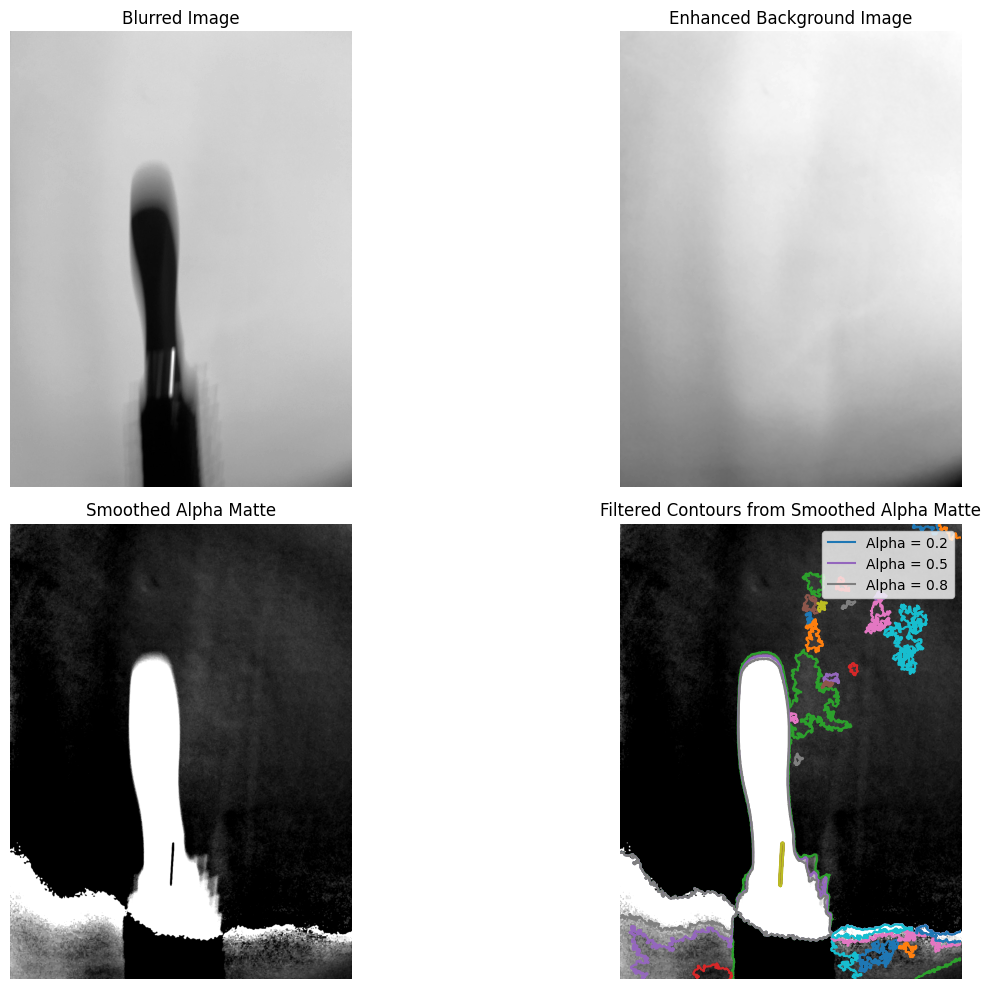

In [25]:

from scipy.ndimage import gaussian_filter, median_filter

# Step 1: Load Image and Preprocess
def load_image(image_path):
    """
    Load and preprocess an image.

    Args:
        image_path (str): Path to the image file.

    Returns:
        numpy.ndarray: Grayscale image normalized to [0, 1].
    """
    image = imread(image_path)
    if len(image.shape) == 3:  # Convert RGB to grayscale if needed
        image = rgb2gray(image)
    return image / 255.0  # Normalize to [0, 1]

# Step 2: Compute Alpha Matte Based on the Paper
def compute_alpha_matte(C, B, o):
    """
    Compute the alpha matte using the paper's formula.

    Args:
        C (numpy.ndarray): Motion-blurred image (C(p)).
        B (numpy.ndarray): Background intensity (B(p)).
        o (float): Object intensity (o(p)).

    Returns:
        numpy.ndarray: Alpha matte values clipped to [0, 1].
    """
    # Avoid division by zero
    denominator = o - B
    denominator[denominator == 0] = np.finfo(float).eps  # Small constant to prevent division by zero

    # Compute alpha matte
    alpha_matte = (C - B) / denominator
    alpha_matte = np.clip(alpha_matte, 0, 1)  # Ensure alpha values are in [0, 1]

    return alpha_matte

# Step 3: Enhance Background
def enhance_background(background_image):
    """
    Apply filtering to the background image to reduce noise.

    Args:
        background_image (numpy.ndarray): Background image.

    Returns:
        numpy.ndarray: Smoothed background image.
    """
    return gaussian_filter(background_image, sigma=2)

# Step 4: Determine Object Intensity
def determine_object_intensity(blurred_image):
    """
    Determine the object intensity based on the central region of the blurred image.

    Args:
        blurred_image (numpy.ndarray): Motion-blurred image.

    Returns:
        float: Estimated object intensity.
    """
    height, width = blurred_image.shape
    central_region = blurred_image[height // 4: 3 * height // 4, width // 4: 3 * width // 4]
    return np.mean(central_region)  # Average intensity of the central region

# Step 5: Smooth Alpha Matte
def smooth_alpha_matte(alpha_matte):
    """
    Apply a median filter to the alpha matte to reduce noise.

    Args:
        alpha_matte (numpy.ndarray): The alpha matte image.

    Returns:
        numpy.ndarray: Smoothed alpha matte.
    """
    return median_filter(alpha_matte, size=3)

# Step 6: Extract Contours
def extract_contours(alpha_matte, levels, min_length=150):
    """
    Extract contours at specific alpha levels from the alpha matte and filter by length.

    Args:
        alpha_matte (numpy.ndarray): The alpha matte image.
        levels (list): Alpha values at which to extract contours.
        min_length (int): Minimum length of contours to retain.

    Returns:
        list: Filtered contours extracted at the specified levels.
    """
    contours = []
    for level in levels:
        contour_set = find_contours(alpha_matte, level)
        filtered_contours = [c for c in contour_set if len(c) > min_length]  # Filter by length
        contours.append((level, filtered_contours))
    return contours

# Parameters
blurred_image_path = "blurred.jpg"  # Path to the motion-blurred image
background_image_path = "background.jpg"  # Path to the background image
alpha_levels = [0.2, 0.5, 0.8]  # Contour levels
min_contour_length = 150  # Minimum length of contours to retain

# Load the blurred and background images
blurred_image = load_image(blurred_image_path)
background_image = load_image(background_image_path)

# Enhance the background
background_image = enhance_background(background_image)

# Determine object intensity
object_intensity = determine_object_intensity(blurred_image)

# Compute alpha matte using the paper's formula
alpha_matte = compute_alpha_matte(blurred_image, background_image, object_intensity)

# Smooth the alpha matte
alpha_matte_smoothed = smooth_alpha_matte(alpha_matte)

# Extract and filter contours
contours = extract_contours(alpha_matte_smoothed, alpha_levels, min_length=min_contour_length)

# Display the results
plt.figure(figsize=(15, 10))

# Display the original blurred image
plt.subplot(2, 2, 1)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image")
plt.axis("off")

# Display the background image
plt.subplot(2, 2, 2)
plt.imshow(background_image, cmap="gray")
plt.title("Enhanced Background Image")
plt.axis("off")

# Display the smoothed alpha matte
plt.subplot(2, 2, 3)
plt.imshow(alpha_matte_smoothed, cmap="gray")
plt.title("Smoothed Alpha Matte")
plt.axis("off")

# Display filtered contours
plt.subplot(2, 2, 4)
plt.imshow(alpha_matte_smoothed, cmap="gray")
used_labels = set()  # Track labels to prevent duplicates
for level, contour_set in contours:
    for contour in contour_set:
        if level not in used_labels:  # Add label only once
            plt.plot(contour[:, 1], contour[:, 0], label=f"Alpha = {level}")
            used_labels.add(level)
        else:
            plt.plot(contour[:, 1], contour[:, 0])  # No label for duplicates
plt.legend(loc="upper right")
plt.title("Filtered Contours from Smoothed Alpha Matte")
plt.axis("off")

plt.tight_layout()
plt.show()
